# Automating Contract Review With Transformer Models

##### Task 1: Import the Libraries

In [1]:
# Standard Libraries
import json
import os

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning & NLP
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

##### Task 2: Generate Dataset Files

In [2]:
# Write convert_json_to_csv() function.
def convert_json_to_csv(json_dir, filename, count):
    with open(json_dir, 'r') as f:
        data = json.load(f)

    # Extract the relevant data and create a DataFrame
    text_list, hypothesis_list, labels_list = [], [], []

    counter = 0  # Counter variable to track the number of appended elements

    for doc in data['documents']:
        annotation_sets = doc.get('annotation_sets', [])
        for annotation_set in annotation_sets:
            annotations = annotation_set.get('annotations', [])
            for annotation in annotations:
                if counter >= count:
                    break  # Break the loop after appending 50 elements

                if isinstance(annotations[annotation], dict):
                    if 'choice' in annotations[annotation]:
                        labels_list.append(annotations[annotation]['choice'])
                        text_list.append(doc['text'])
                        hypothesis_list.append(data['labels'][annotation]['hypothesis'])
                        counter += 1  # Increment the counter

    if len(text_list) == len(hypothesis_list) and len(hypothesis_list) == len(labels_list):
        df = pd.DataFrame({'text': text_list, 'hypothesis': hypothesis_list, 'labels': labels_list})
        # Save the DataFrame to a CSV file
        df.to_csv(filename, index=False)

In [3]:
# Call convert_json_to_csv() function for training, validation and testing.
directory_path = '/usercode/Contract-nli Dataset/'
train_file_name = 'train_df.csv'
validation_file_name = 'valid_df.csv'
testing_file_name = 'test_df.csv'

## For training
convert_json_to_csv(directory_path+'train.json', directory_path+train_file_name, count = 35)
## For validation
convert_json_to_csv(directory_path+'valid.json', directory_path+validation_file_name, count = 10)
## For testing
convert_json_to_csv(directory_path+'test.json', directory_path+testing_file_name, count = 5)


##### Task 3: Calculate Dataset Statistics

In [4]:
# 1. Load the dataset
train_df = pd.read_csv(directory_path+train_file_name)
valid_df = pd.read_csv(directory_path+validation_file_name)
test_df = pd.read_csv(directory_path+testing_file_name)

In [5]:
# 2. Display the first and last 5 rows of the training dataset
print(train_df.head(5))
print(train_df.tail(5))

                                                text  \
0  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
1  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
2  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
3  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
4  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   

                                          hypothesis        labels  
0  Receiving Party shall not reverse engineer any...  NotMentioned  
1  Receiving Party shall destroy or return some C...    Entailment  
2  Agreement shall not grant Receiving Party any ...    Entailment  
3  Receiving Party shall not disclose the fact th...    Entailment  
4  Confidential Information shall only include te...  NotMentioned  
                                                 text  \
30  NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...   
31  NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...   
32  NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...   
33  NON-DISCLOSURE AG

In [6]:
# 3. Display the dimension of the training data
train_df.shape

(35, 3)

In [7]:
# 4. Display a summary of the training DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        35 non-null     object
 1   hypothesis  35 non-null     object
 2   labels      35 non-null     object
dtypes: object(3)
memory usage: 968.0+ bytes


In [8]:
# 5. Print the statistical summary of the training, validation, and testing DataFrames
print(train_df.describe(include = 'all'))
print(valid_df.describe(include = 'all'))
print(test_df.describe(include = 'all'))

                                                     text  \
count                                                  35   
unique                                                  3   
top     NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
freq                                                   17   

                                               hypothesis      labels  
count                                                  35          35  
unique                                                 17           3  
top     Receiving Party shall not reverse engineer any...  Entailment  
freq                                                    3          18  
                                                     text  \
count                                                  10   
unique                                                  1   
top     OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
freq                                                   10   

                            

##### Task 4: Create Visualization Function for Features

In [9]:
# Write visualize_features() function
def visualize_features(dataset, datatype , col_name, target):
    # Calculate the average length of each document
    doc_lengths = dataset[col_name].apply(len)
    avg_doc_length = doc_lengths.mean()

    # Determine the minimum, maximum, and median lengths of the documents
    min_doc_length = doc_lengths.min()
    max_doc_length = doc_lengths.max()
    median_doc_length = doc_lengths.median()

    print(f"Average document length for {datatype}: {avg_doc_length:.2f} characters")
    # Min, max, and median length of documents
    print(f"Min {target} length for {datatype}: {min_doc_length} characters")
    print(f"Max {target} length for {datatype}: {max_doc_length} characters")
    print(f"Median {target} length for {datatype}: {median_doc_length} characters")
    print("-------------------------------------------------------------------------")
    # Plot box plots of document lengths and hypothesis lengths
    plt.hist(doc_lengths, bins = 50)
    # Set labels and title
    plt.title(f"Distribution of {target} Lengths for {datatype}")
    plt.xlabel(f"{target} Length (characters)")
    plt.ylabel("Count")
    # Display the plot
    plt.show()

Average document length for training: 97.60 characters
Min hypothesis length for training: 66 characters
Max hypothesis length for training: 162 characters
Median hypothesis length for training: 90.0 characters
-------------------------------------------------------------------------


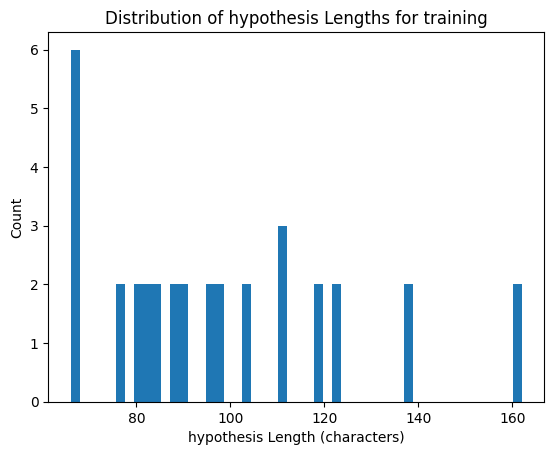

Average document length for validation: 87.50 characters
Min hypothesis length for validation: 66 characters
Max hypothesis length for validation: 122 characters
Median hypothesis length for validation: 83.5 characters
-------------------------------------------------------------------------


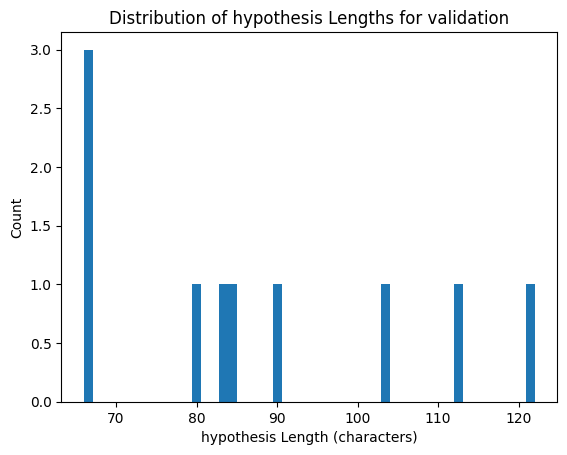

Average document length for testing: 89.20 characters
Min hypothesis length for testing: 66 characters
Max hypothesis length for testing: 112 characters
Median hypothesis length for testing: 84.0 characters
-------------------------------------------------------------------------


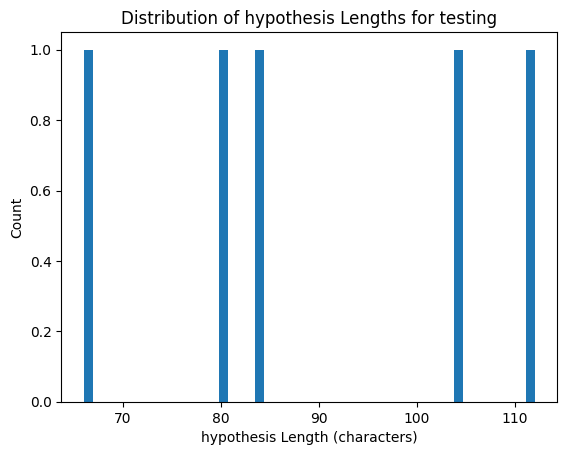

In [10]:
# Call visualize_features() function for training, validation and testing
visualize_features(train_df, "training", "hypothesis", "hypothesis")
visualize_features(valid_df, "validation", "hypothesis", "hypothesis")
visualize_features(test_df, "testing", "hypothesis", "hypothesis")

##### Task 5: Create Visualizations Function for Labels

In [11]:
# Write visualize_label() function
def visualize_label(dataset, data_type):
   print(f"Visualize labels for the {data_type}")
   label_counts = dataset['labels'].value_counts()
   print("The labels and corresponding counts\n", label_counts)

   # Create a bar chart to visualize the label distribution
   plt.bar(label_counts.index, label_counts.values)
   # Display the plot
   plt.show()

Visualize labels for the training
The labels and corresponding counts
 labels
Entailment       18
NotMentioned     13
Contradiction     4
Name: count, dtype: int64


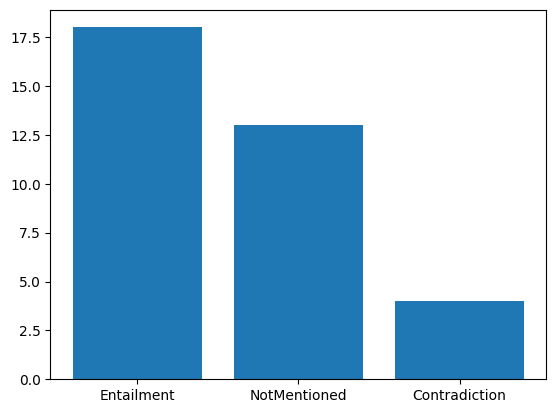

Visualize labels for the validation
The labels and corresponding counts
 labels
Entailment       9
Contradiction    1
Name: count, dtype: int64


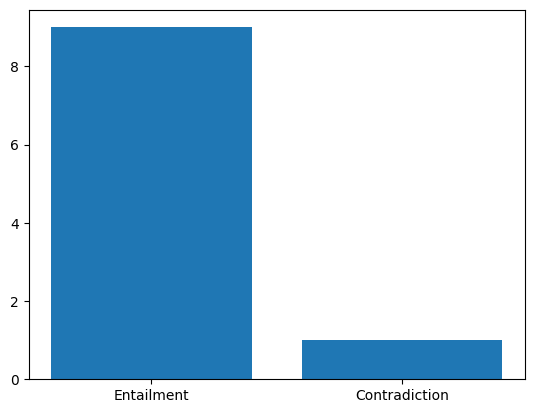

Visualize labels for the testing
The labels and corresponding counts
 labels
NotMentioned     2
Entailment       2
Contradiction    1
Name: count, dtype: int64


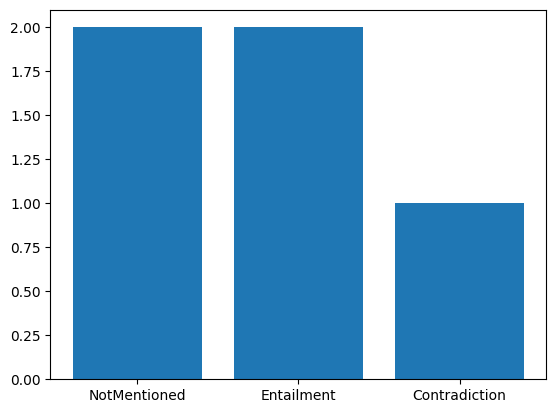

In [12]:
# Call visualize_label() function for training, validation and testing.
visualize_label(train_df, "training")
visualize_label(valid_df, "validation")
visualize_label(test_df, "testing")

##### Task 6: Load the Tokenizer and Model

In [13]:
# ALBERT tokenizer and model
albert_model_name = "albert-base-v2"
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)
albert_classifier_model = AutoModelForSequenceClassification.from_pretrained(albert_model_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# DistilBERT tokenizer and model
distilbert_model_name = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_classifier_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Task 7: Encode the Features

In [15]:
# Write tokenize_data() function
def tokenize_data(data, tokenizer):
   # Tokenize the features 
   return tokenizer(text = data['text'].tolist(), text_pair = data['hypothesis'].tolist(), padding = "max_length", max_length = 256, truncation = True)    

In [16]:
# Call tokenize_data() function for training, validation and testing.
## ALBERT model
albert_train_encodings = tokenize_data(train_df, albert_tokenizer)
albert_valid_encodings = tokenize_data(valid_df, albert_tokenizer)
albert_test_encodings = tokenize_data(test_df, albert_tokenizer)

# DistilBERT model
distilbert_train_encodings = tokenize_data(train_df, distilbert_tokenizer)
distilbert_valid_encodings = tokenize_data(valid_df, distilbert_tokenizer)
distilbert_test_encodings = tokenize_data(test_df, distilbert_tokenizer)

##### Task 8: Encode the Label

In [29]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['labels'].tolist()]

valid_labels = [label_mapping[label] for label in valid_df['labels'].tolist()]

test_labels = [label_mapping[label] for label in test_df['labels'].tolist()]

##### Task 9: Prepare Dataset for the Model

In [30]:
# Write ContractNLIDataset() class. 
class ContractNLIDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
    # Here, ensure the label is an integer tensor
    item['labels'] = torch.tensor(int(self.labels[idx]))
    return item

  def __len__(self):
    return len(self.labels)

In [31]:
# Create the objects from ContractNLIDataset() class for training, validation and testing.
## ALBERT model
albert_train_dataset = ContractNLIDataset(albert_train_encodings, train_labels)
albert_valid_dataset = ContractNLIDataset(albert_valid_encodings, valid_labels)
albert_test_dataset = ContractNLIDataset(albert_test_encodings, test_labels)

## DistilBERT model
distilbert_train_dataset = ContractNLIDataset(distilbert_train_encodings, train_labels)
distilbert_valid_dataset = ContractNLIDataset(distilbert_valid_encodings, valid_labels)
distilbert_test_dataset = ContractNLIDataset(distilbert_test_encodings, test_labels)

##### Task 10: Fine-Tune the Selected Models

In [32]:
# Write compute_metrics() function. 
def compute_metrics(p):
  preds = np.argmax(p.predictions, axis = 1)
  labels = p.label_ids

  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average = 'macro', zero_division=0)
  recall = recall_score(labels, preds, average = 'macro', zero_division=0)
  f1 = f1_score(labels, preds, average = 'macro')

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [33]:
# configure the training setting
training_args = TrainingArguments(
 output_dir = directory_path+'results',
 num_train_epochs = 3,
 weight_decay = 0.01,
 logging_steps = 1,
 evaluation_strategy = "epoch",
 )

In [34]:
# Write train_fn() function
def train_fn(model,train_dataset,eval_dataset, tokenizer):
    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        tokenizer = tokenizer,
        compute_metrics = compute_metrics,)

    trainer.train()
    return trainer

In [35]:
# Call train_fn() function

# ALBERT model
albert_trainer = train_fn(albert_classifier_model, albert_train_dataset, albert_valid_dataset, albert_tokenizer)
# DistilBERT model
distilbert_trainer = train_fn(distilbert_classifier_model, distilbert_train_dataset, distilbert_valid_dataset, distilbert_tokenizer)

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.582200,0.476063,0.900000,0.450000,0.500000,0.473684
2,0.770200,0.499272,0.900000,0.450000,0.500000,0.473684
3,0.758900,0.489563,0.900000,0.450000,0.500000,0.473684


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.926000,0.905740,0.900000,0.450000,0.500000,0.473684
2,0.887800,0.854636,0.900000,0.450000,0.500000,0.473684
3,0.910200,0.845329,0.900000,0.450000,0.500000,0.473684


##### Task 11: Test the Selected Models

In [36]:
# Write predict_and_save_results() function
def predict_and_save_results(trainer, model, model_name, test_dataset):
  prediction_output = trainer.predict(test_dataset)
  test_df[f'pred_from_{model_name}'] = np.argmax(prediction_output[0], axis = 1)     

In [37]:
# Call predict_and_save_results() function.
## ALBERT model
predict_and_save_results(albert_trainer, albert_classifier_model, albert_model_name, albert_test_dataset)

## DistilBERT model
predict_and_save_results(distilbert_trainer, distilbert_classifier_model, distilbert_model_name, distilbert_test_dataset)

##### Task 12: Identify Incorrect Predictions

In [38]:
albert_col_name = 'pred_from_'+ albert_model_name
distilbert_col_name = 'pred_from_'+ distilbert_model_name

## ALBERT model
print(test_df[albert_col_name] == test_labels)
## DistilBERT model
print(test_df[distilbert_col_name] == test_labels)

0    False
1     True
2     True
3    False
4    False
Name: pred_from_albert-base-v2, dtype: bool
0    False
1     True
2     True
3    False
4    False
Name: pred_from_distilbert-base-uncased, dtype: bool


##### Task 13: Categorize the Errors

In [39]:

# For the ALBERT model
albert_misclass = test_df[test_df[albert_col_name]!= test_labels].iloc[:,:3]
print(albert_misclass)
# For the DistilBERT model
distilbert_misclass = test_df[test_df[distilbert_col_name]!= test_labels].iloc[:,:3]
print(distilbert_misclass)

                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contradiction  
                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contra

##### Task 14: Visualize Error Categories

Visualize labels for the testing
The labels and corresponding counts
 labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


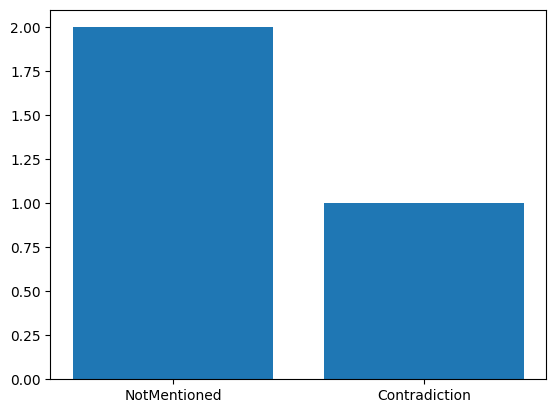

Average document length for testing: 16632.00 characters
Min text length for testing: 16632 characters
Max text length for testing: 16632 characters
Median text length for testing: 16632.0 characters
-------------------------------------------------------------------------


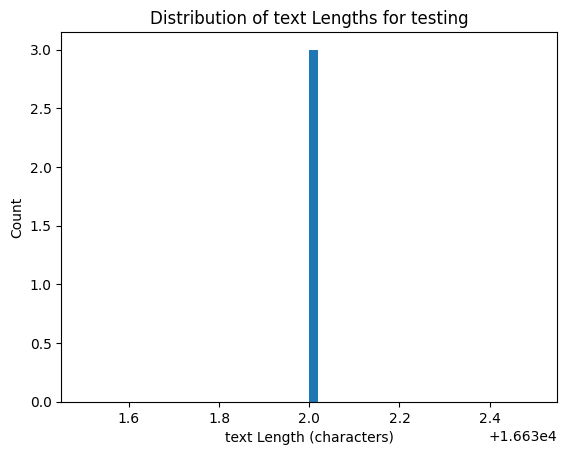

Average document length for testing: 87.33 characters
Min hypothesis length for testing: 66 characters
Max hypothesis length for testing: 112 characters
Median hypothesis length for testing: 84.0 characters
-------------------------------------------------------------------------


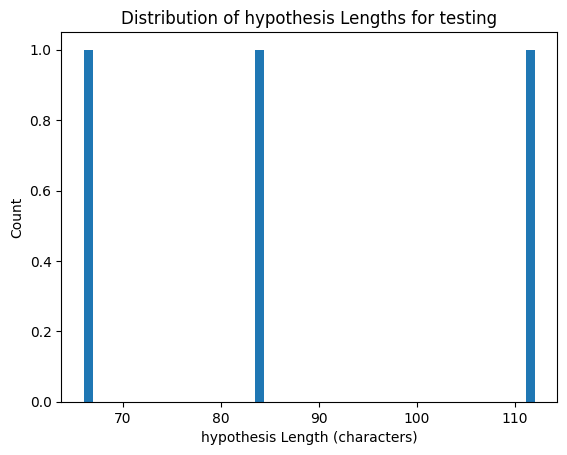

In [40]:
## ALBERT model
visualize_label(albert_misclass, "testing")
visualize_features(albert_misclass, "testing", "text", "text")
visualize_features(albert_misclass, "testing", "hypothesis", "hypothesis")

Visualize labels for the testing
The labels and corresponding counts
 labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


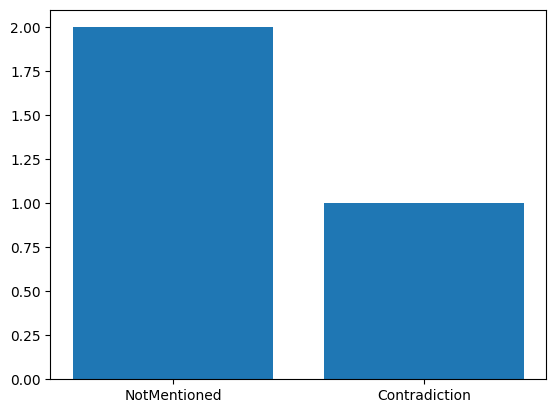

Average document length for testing: 16632.00 characters
Min text length for testing: 16632 characters
Max text length for testing: 16632 characters
Median text length for testing: 16632.0 characters
-------------------------------------------------------------------------


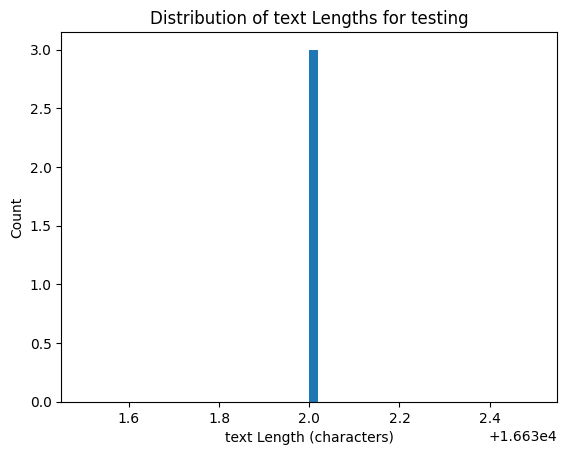

Average document length for testing: 87.33 characters
Min hypothesis length for testing: 66 characters
Max hypothesis length for testing: 112 characters
Median hypothesis length for testing: 84.0 characters
-------------------------------------------------------------------------


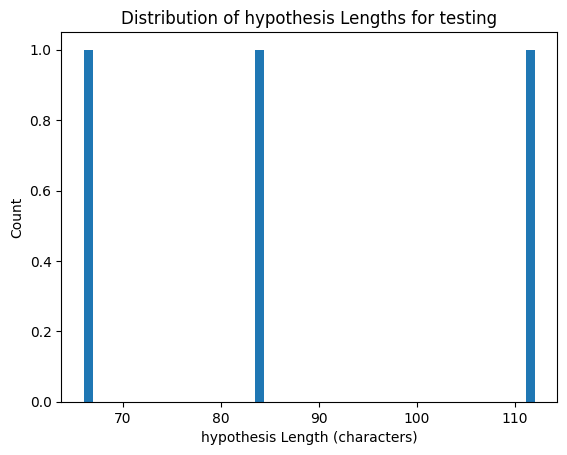

In [41]:
## DistilBERT model
visualize_label(distilbert_misclass, "testing")
visualize_features(distilbert_misclass, "testing", "text", "text")
visualize_features(distilbert_misclass, "testing", "hypothesis", "hypothesis")